<h1> <img src="https://drive.google.com/uc?export=view&id=1Zk4765E2Mznp9on3gSs269PL-N6S-vQZ" width="70"> <strong>Large Action Models, Tool Calling and MCP Agents</strong></h1>


```
Author: 🎤Lorenzo Molfetta
Professor: Gianluca Moro

{name}.{surname}@unibo.it
```

_Alma Mater Studiorum Università di Bologna_

**Course**: TextMining & LLMs

**Research Group**: <mark><strong>UniboNLP@Cesena</strong></mark>

**Our website**: [link](https://disi-unibo-nlp.github.io)

<img src="https://drive.google.com/uc?export=view&id=1uskMMZ3v4QSDkC-eH5wTiTMmKiVfZFHs" width="300">


In this notebook, we will explore the concepts of Large Action Models (LAMs) and Agents and demonstrate their practical implementation in a variety of real-world scenarios. LAMs extend the capabilities of traditional AI systems by integrating tool-calling mechanisms, enabling efficient problem-solving across diverse domains. This hands-on exploration is designed to showcase how agents can be applied effectively to solve real-life challenges.


We will tackle the following tasks:
- [📊 Analytical Tool on Company Stability and Trend](#financial): use agents to evaluate the financial stability and future trends of a company, employing advanced analytics and visualization techniques.
- [☎️ Hotline Customer Service for Ticket Management](#hotline): automate and streamline customer support processes using AI-driven tools to efficiently manage service tickets.
- [📤 Model Conxtext Protocol](#mcp): define an agentic pipeline using the MCP formalism


> Additional resources on the development of a GUI Agent and the implementation of a multi-agent MCP system are available at https://github.com/disi-unibo-nlp/mcp_agents_lecture

# 🤗 Local Open Source LLMs with Transformers

We are going to use open-source models from HuggingFace. So paste you key into the Colab `Secrets` 🔑 panel (on the left, above `Files`) and make it visibile to the notebook.

In [ ]:
from google.colab import userdata
import os

os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

<a name="financial"></a>
#  📊 Financial Statement Analysis

In this section, we are going to implement a LAM for companies' financial analysis using LlamaIndex 🦙.

In [ ]:
%pip install llama-index==0.14.10 \
             llama-index-llms-huggingface==0.6.1 \
             llama-index-embeddings-huggingface==0.6.1 \
             accelerate==1.12.0 \
             bitsandbytes==0.48.2 \
             transformers==4.57.3 \
             pydantic==2.12.5

> **RESTART** the environment.

In [ ]:
import json
from llama_index.core.tools import FunctionTool
from pydantic import Field
from typing import Union, List

import nest_asyncio
from transformers import set_seed

from llama_index.llms.huggingface import HuggingFaceLLM
from transformers import AutoTokenizer
from transformers import BitsAndBytesConfig
import torch
import warnings

SEED=42
set_seed(42)

nest_asyncio.apply()

Let's define some very simple calculator tools for our agent.

In [ ]:
def multiply(factor_1: int,
             factor_2: int) -> int:
    """Multiple two integers and returns the result integer"""
    return factor_1 * factor_2


multiply_tool = FunctionTool.from_defaults(fn=multiply)

In [ ]:
def add(addend_1: int,
        addend_2: int) -> int:
    """Add two integers and returns the result integer"""
    return addend_1 + addend_2


add_tool = FunctionTool.from_defaults(fn=add)

In [ ]:
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

In [ ]:
with warnings.catch_warnings():
    # For pydantic
    warnings.simplefilter("ignore", UserWarning)

    # Set padding configs
    #tokenizer.pad_token = tokenizer.eos_token
    #tokenizer.pad_token_id = tokenizer.eos_token_id

    # OPTIONAL
    # Define quantization configuration
    quantization_configs = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True)

    # Load the model from HuggingFace using automatic chat template
    llm = HuggingFaceLLM(
        model_name=MODEL_NAME,
        max_new_tokens=8192,
        model_kwargs={
            "trust_remote_code": True,
            "attn_implementation" : "eager",
            "quantization_config" : quantization_configs
        },
        generate_kwargs={
            "do_sample": True,
            "temperature": 0.7,
            "top_k" : 20,
            "top_p" : 0.8,
            "min_p" : 0.0
        },
        #tokenizer=tokenizer,
        tokenizer_name=MODEL_NAME,
        is_chat_model=True # we will use an instruct model with automatic chat template
    )

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
from typing import Dict
from llama_index.llms.openai.utils import OpenAIToolCall
import re

def custom_tool_call_parser(tool_call: OpenAIToolCall) -> Dict:
    r"""Parse tool calls that are not standard json.
    Also parses tool calls of the following forms:
    variable = \"\"\"Some long text\"\"\"
    variable = "Some long text"'
    variable = '''Some long text'''
    variable = 'Some long text'
    """
    arguments_str = tool_call.function.arguments
    if len(arguments_str.strip()) == 0:
        # OpenAI returns an empty string for functions containing no args
        return {}
    try:
        tool_call = json.loads(arguments_str)
        if not isinstance(tool_call, dict):
            raise ValueError("Tool call must be a dictionary")
        return tool_call
    except json.JSONDecodeError as e:
        # pattern to match variable names and content within quotes
        pattern = r'([a-zA-Z_][a-zA-Z_0-9]*)\s*=\s*["\']+(.*?)["\']+'
        match = re.search(pattern, arguments_str)

        if match:
            variable_name = match.group(1)  # This is the variable name
            content = match.group(2)  # This is the content within the quotes
            return {variable_name: content}
        raise ValueError(f"Invalid tool call: {e!s}")

### Mathematical Operations

It is well-known that LLMs are not good at mathematic. With a LAM system, however, we can implement a language-augmented calculator.

In [ ]:
from llama_index.core.agent import ReActAgent, ReActChatFormatter
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import BaseTool, FunctionTool
from llama_index.core.agent.workflow import AgentStream, ToolCallResult


# Utils for agent inference
from IPython.display import display, HTML, clear_output

COLORS = {
    'Thought:': '<br><span style="color:cyan;font-weight:bold">Thought:</span>',
    'Action:': '<br><span style="color:orange;font-weight:bold">Action:</span>',
    'Action Input:': '<br><span style="color:magenta;font-weight:bold">Action Input:</span>',
    'Answer:': '<br><span style="color:green;font-weight:bold">Answer:</span>',
    'Observation:': '<br><span style="color:blue;font-weight:bold">Observation:</span>',
}

async def run_agent(query: str):
    handler = agent.run(query)
    output = ""

    async for ev in handler.stream_events():
        if isinstance(ev, AgentStream):
            output += ev.delta

        elif isinstance(ev, ToolCallResult):
            # get the tool output
            tool_result = str(ev.tool_output)
            last_input_index = output.rfind("Action Input:")

            # handle intermediate observations
            if last_input_index != -1:
                observation_index = output.find("Observation:", last_input_index)
                if observation_index != -1:
                    output = output[:observation_index].rstrip()
            output += f"\nObservation: {tool_result}\n"

        # render the react logic
        styled = output
        for kw, html in COLORS.items():
            styled = styled.replace('\n' + kw, html).replace(kw, html)

        clear_output(wait=True)
        display(HTML(f"<pre>{styled}</pre>"))

    return await handler

We can now define a ReAct-based agent.

In [ ]:
agent = ReActAgent(
    tools=[multiply_tool, add_tool],
    llm=llm,
    verbose=True, # <-- enable to see react intermediate reasoning
    tool_call_parser=custom_tool_call_parser,
)

Let's have a look at the agent's prompt:

In [ ]:
prompt_dict = agent.get_prompts()
for k, v in prompt_dict.items():
    print(f"Prompt: {k}\n\nValue: {v.template}")

Prompt: react_header

Value: You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.

## Tools

You have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.
This may require breaking the task into subtasks and using different tools to complete each subtask.

You have access to the following tools:
{tool_desc}


## Output Format

Please answer in the same language as the question and use the following format:

```
Thought: The current language of the user is: (user's language). I need to use a tool to help me answer the question.
Action: tool name (one of {tool_names}) if using a tool.
Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
```

Please ALWAYS start with a Thought.

NEVER surround your response with markdown code markers. You may use code mark

We can now prompt some mathematical questions.

In [ ]:
result = await run_agent("What is 20+(2*4)?")

In [ ]:
result = await run_agent("What is (3 * 20) + ( 2 * (4+10) )?")

In [ ]:
import json
def print_tool_output(out_tool):

  out_dict = {
      "tool_name" : out_tool.tool_name,
      "inputs" : {
          "args" :  out_tool.tool_output.raw_input.get("args",""),
          "kwargs" : out_tool.tool_output.raw_input.get("kwargs","")
      },
      "outputs" : out_tool.tool_output.raw_output,
      "threw_error" : out_tool.tool_output.is_error
  }

  print(json.dumps(out_dict, indent=3))

In [ ]:
for tool_idx, tool_used in enumerate(result.tool_calls):
  print("-"*50)
  print(f"Function call {tool_idx + 1}")
  print_tool_output(tool_used)

--------------------------------------------------
Function call 1
{
   "tool_name": "multiply",
   "inputs": {
      "args": [],
      "kwargs": {
         "factor_1": 3,
         "factor_2": 20
      }
   },
   "outputs": 60,
   "threw_error": false
}
--------------------------------------------------
Function call 2
{
   "tool_name": "add",
   "inputs": {
      "args": [],
      "kwargs": {
         "addend_1": 4,
         "addend_2": 10
      }
   },
   "outputs": 14,
   "threw_error": false
}
--------------------------------------------------
Function call 3
{
   "tool_name": "multiply",
   "inputs": {
      "args": [],
      "kwargs": {
         "factor_1": 2,
         "factor_2": 14
      }
   },
   "outputs": 28,
   "threw_error": false
}
--------------------------------------------------
Function call 4
{
   "tool_name": "add",
   "inputs": {
      "args": [],
      "kwargs": {
         "addend_1": 60,
         "addend_2": 28
      }
   },
   "outputs": 88,
   "threw_error": f

### Database Interaction w/ generated SQL queries
We can now implement the LAM system for financial analysis. The model will be endowed with SQL capabilities for accessing information stored in a relational database.

### Database Creation
Let's create a mock database with some information about made up companies.

In [ ]:
import sqlite3
import datetime

def setup_company_payments_db(db_name='company_payments.db'):
    """
    Sets up a local SQLite database with diversified company and payment data.
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Enable foreign key constraints
    cursor.execute('PRAGMA foreign_keys = ON;')

    # Drop tables if they already exist to start fresh (optional)
    cursor.execute('DROP TABLE IF EXISTS payments;')
    cursor.execute('DROP TABLE IF EXISTS companies;')

    # Create companies table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS companies (
            company_id INTEGER PRIMARY KEY AUTOINCREMENT,
            company_name TEXT NOT NULL,
            industry TEXT NOT NULL,
            headquarters TEXT NOT NULL
        );
    ''')

    # Create payments table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS payments (
            payment_id INTEGER PRIMARY KEY AUTOINCREMENT,
            company_id INTEGER NOT NULL,
            payment_date TEXT NOT NULL,
            payment_amount REAL NOT NULL,
            FOREIGN KEY (company_id) REFERENCES companies(company_id)
        );
    ''')

    # Insert sample companies
    companies_data = [
        ('AlphaTech', 'Technology', 'San Francisco'),
        ('BetaFinance', 'Finance', 'New York'),
        ('GammaHealth', 'Healthcare', 'Chicago'),
        ('DeltaTech', 'Technology', 'San Francisco'),
        ('EpsilonRetail', 'Retail', 'Seattle'),
    ]

    cursor.executemany('''
        INSERT INTO companies (company_name, industry, headquarters)
        VALUES (?, ?, ?);
    ''', companies_data)

    # Retrieve company IDs and map them to company names
    cursor.execute('SELECT company_id, company_name FROM companies;')
    company_ids = cursor.fetchall()
    company_id_map = {name: cid for cid, name in company_ids}

    # Insert sample payments
    payments_data = []
    for month in range(1, 13):
        date_str = f'2023-{month:02d}-15'  # Dates like '2023-01-15'
        # Payments for AlphaTech and DeltaTech (Technology companies in San Francisco)
        payments_data.extend([
            (company_id_map['AlphaTech'], date_str, 5000 + month * 200),
            (company_id_map['DeltaTech'], date_str, 7000 + month * 250),
        ])
        # Payments for other companies
        payments_data.extend([
            (company_id_map['BetaFinance'], date_str, 8000 + month * 300),
            (company_id_map['GammaHealth'], date_str, 6000 + month * 150),
            (company_id_map['EpsilonRetail'], date_str, 5500 + month * 180),
        ])

    cursor.executemany('''
        INSERT INTO payments (company_id, payment_date, payment_amount)
        VALUES (?, ?, ?);
    ''', payments_data)

    conn.commit()
    conn.close()

setup_company_payments_db()

In [ ]:
# Test connection to database
conn = sqlite3.connect("company_payments.db")
cursor = conn.cursor()

QQ="""
SELECT company_id
FROM payments
WHERE payment_date BETWEEN "2023-01-01" AND "2023-12-31"
GROUP BY company_id ORDER BY SUM(payment_amount) DESC LIMIT 1
"""

cursor.execute(QQ.strip())
results = cursor.fetchall()

# Display the results
print("Payment data:")
print(results)

# Close the connection
conn.close()

Payment data:
[(2,)]


### Tool Definition

We can now define tools for interacting with the database and send emails.

You can define tool functions' parameters either with a pythonic formalism or with a more structured definition using the pydantic Field class.

In [ ]:
from llama_index.core.tools import ToolMetadata, FunctionTool
import sqlite3

In [ ]:
def execute_sql_query(sql_query: str, db_name: str = 'company_payments.db') -> str:
    """
    Executes a SQL query against the company payments database.

    Args:
        sql_query (str): The SQL command to execute.
                         (Renaming this variable helps the LLM match the key).
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    try:
        # Match the variable name here
        cursor.execute(sql_query)
        rows = cursor.fetchall()

        if not rows:
            results = "Query executed successfully but returned no results."
        else:
            results = str(rows)

    except Exception as e:
        results = f"SQL Error: {str(e)}"
    finally:
        conn.close()

    return results

# Tool Definition
execute_sql_tool = FunctionTool.from_defaults(
    fn=execute_sql_query,
    tool_metadata=ToolMetadata(
        name="execute_sql_query",
        # Explicitly mention the argument name in the description to guide the LLM
        description=(
            "Executes a SQL query. "
            "REQUIRED parameter: 'sql_query' (string). "
            "Example: {\"sql_query\": \"SELECT * FROM companies\"}"
        )
    )
)

In [ ]:
def get_database_schema() -> str:
    """
    Returns the schema for all tables in the database (companies and payments).
    """
    return """
Table: `companies`
Columns:
  - `company_id` (INTEGER PRIMARY KEY): Unique identifier.
  - `company_name` (TEXT): Name of the company.
  - `industry` (TEXT): Industry sector.
  - `headquarters` (TEXT): Location.

Table: `payments`
Columns:
  - `payment_id` (INTEGER PRIMARY KEY): Unique identifier.
  - `company_id` (INTEGER): Foreign Key -> companies.company_id.
  - `payment_date` (TEXT): Date in 'YYYY-MM-DD'.
  - `payment_amount` (REAL): Transaction value.  <-- CORRECTED NAME
"""

schema_tool = FunctionTool.from_defaults(
    fn=get_database_schema,
    tool_metadata=ToolMetadata(
        name="get_database_schema",
        description="Returns the full database schema for all tables in the database with columns and foreign keys."
    )
)

In [ ]:
def generate_sql_query(table : str ='payments',
                       columns : Union[str, List[str]] ='*',
                       conditions : Union[str, List[str]]='1=1') -> str:
    """
    Generates a SQL SELECT query based on the provided parameters.
    """
    if isinstance(columns, list):
        columns = ', '.join(columns)
    query = f"SELECT {columns} FROM {table}"
    if conditions:
        if isinstance(conditions, list):
            conditions = ' AND '.join(conditions)
        query += f" WHERE {conditions}"
    query += ";"
    return query

generate_sql_query_interface = FunctionTool.from_defaults(
    tool_metadata=ToolMetadata(
        name="generate_sql_query",
        description="Generates a SQL SELECT query based on table, columns, and conditions."
    ),
    fn=generate_sql_query
)

In [ ]:
def query_payments_db(input : str = "SELECT * FROM payments;",
                      db_name : str = 'payments.db') -> list:
    """
    Executes an SQL query against the payments database.
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    try:
        cursor.execute(input)
        results = cursor.fetchall()
    except Exception as e:
        results = f"An error occurred: {e}"
    finally:
        conn.close()

    print("*"*10)
    print(results)
    print("*"*10)

    return results

query_payments_db_interface = FunctionTool.from_defaults(
    tool_metadata=ToolMetadata(
        name="query_payments_db",
        description="Executes an SQL query against the payments database."
    ),
    fn=query_payments_db
)

In [ ]:
def send_email(to: str, subject: str, body: str) -> str:
    """
    Simulates sending an email by writing to a file.

    Args:
        to (str): The recipient's email address.
        subject (str): The subject of the email.
        body (str): The main content of the email.
    """
    # 1. Create the email content
    email_content = f"""
From: lam.system@gmail.com
To: {to}
Subject: {subject}

{body}
"""
    # 2. "Send" it (write to file)
    out_path = 'tmp_email_repo.txt'
    with open(out_path, "w") as f_out:
        f_out.write(email_content)

    # Return message to notify the LLM the task was completed successfully
    success_msg = f"The email to {to} was written and sent with SUCCESS. Well done. The task has been fulfilled."
    print(success_msg)

    return success_msg

send_email_tool = FunctionTool.from_defaults(
    fn=send_email,
    tool_metadata=ToolMetadata(
        name="send_email",
        description=(
            "Sends an email to a specific recipient. "
            "You must provide three specific arguments: 'to', 'subject', and 'body'. "
            "CRITICAL: The 'body' content MUST be concise (under 200 words)."
            "Summarize findings briefly; do not write long reports."
        )
    )
)

### Agent Implementation
We can now regulate the behaviour of our system

In [ ]:
tools = [multiply_tool,
         add_tool,
         execute_sql_tool,
         send_email_tool,
         schema_tool]

agent = ReActAgent(
    tools=tools,
    llm=llm,
    verbose=True,
    tool_call_parser=custom_tool_call_parser,
    max_iterations=30
)

In [ ]:
user_query = """
Find the the company ID with 'the higher total payment amount over the year 2023.
Then do the same with the worst company in the same period. Finally retrieve the company names.
"""

In [ ]:
response = await run_agent(user_query)

In [ ]:
user_query = """
Calculate the total payments amount made by the AlphaTech company over the 2023 year,
multiply it by 1.05 to project next year's payments with a 5% growth.
Then draw a comparison with the average payments amount from all companies.
"""

In [ ]:
response = await run_agent(user_query)

In [ ]:
user_query = """
Calculate the total payments amount made by the AlphaTech company over the 2023 year,
multiply it by 1.05 to project next year's payments with a 5% growth.
Then draw a comparison with the average payments amount from all companies.
At the end of the analysis, plase **send an email** to "lorenzo.molfetta@unibo.it" (receiver)
with all these insights and your personal analysis on the economic situations of AlphaTech.
"""

In [ ]:
response = await run_agent(user_query)

In [ ]:
for tool_idx, tool_used in enumerate(response.tool_calls):
  print("-"*50)
  print(f"Function call {tool_idx + 1}")
  print_tool_output(tool_used)

--------------------------------------------------
Function call 1
{
   "tool_name": "get_database_schema",
   "inputs": {
      "args": "",
      "kwargs": ""
   },
   "outputs": "get_database_schema() got an unexpected keyword argument 'input'",
   "threw_error": true
}
--------------------------------------------------
Function call 2
{
   "tool_name": "get_database_schema",
   "inputs": {
      "args": [],
      "kwargs": {}
   },
   "outputs": "\nTable: `companies`\nColumns:\n  - `company_id` (INTEGER PRIMARY KEY): Unique identifier.\n  - `company_name` (TEXT): Name of the company.\n  - `industry` (TEXT): Industry sector.\n  - `headquarters` (TEXT): Location.\n\nTable: `payments`\nColumns:\n  - `payment_id` (INTEGER PRIMARY KEY): Unique identifier.\n  - `company_id` (INTEGER): Foreign Key -> companies.company_id.\n  - `payment_date` (TEXT): Date in 'YYYY-MM-DD'.\n  - `payment_amount` (REAL): Transaction value.  <-- CORRECTED NAME\n",
   "threw_error": false
}
---------------------

<a name="hotline"></a>
# ☎️ Hotline Customer Service for Ticket Resolve

In this part, we are going to develop a system for handling customer requests and authomatic ticket management.

In [ ]:
import re
import warnings
from typing import Union, List, Dict

import torch
import nest_asyncio
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from transformers import (
    set_seed,
    BitsAndBytesConfig,
    AutoTokenizer
)

from datasets import load_dataset
import sqlite3

from llama_index.core.tools import ToolMetadata, FunctionTool
from llama_index.core.agent import ReActAgent, ReActChatFormatter
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.openai.utils import OpenAIToolCall
from pydantic import Field

set_seed(42)

nest_asyncio.apply()

## Load and Parse Datasets

Since no suitable datasets currently exist in this domain, we created a new one using`Llama-3.1-70B`.

Let's download and analyze these datasets.

In [ ]:
import os
import gdown

tables_link = {
    "products" : "1D37n1-qVHgg6g7MfrPl-wKqWhx6NFhfn",
    "experts" : "1nQs3de_IYncosmE5VMZkkgHTXvjtYwv_",
    "users" : "1deoFGMHAPnQmah7O9qua82-vWB1kLfrw",
    "tickets" : "1Xsqemxgv_MKYLbjqreBMylpiy_jOkC_h"
}

OUT_FOLDER = "/content/hotline_datasets"
os.system(f"mkdir -p {OUT_FOLDER}")

for table_name in tables_link:
  print(f"Downloading {table_name} dataset...")
  url = "https://drive.google.com/uc?id=" + tables_link[table_name]
  output = os.path.join(OUT_FOLDER, table_name) + ".csv"

  gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1D37n1-qVHgg6g7MfrPl-wKqWhx6NFhfn
To: /content/hotline_datasets/products.csv
100%|██████████| 74.7k/74.7k [00:00<00:00, 80.7MB/s]


Downloading...
From: https://drive.google.com/uc?id=1nQs3de_IYncosmE5VMZkkgHTXvjtYwv_
To: /content/hotline_datasets/experts.csv
100%|██████████| 866/866 [00:00<00:00, 2.20MB/s]


Downloading...
From: https://drive.google.com/uc?id=1deoFGMHAPnQmah7O9qua82-vWB1kLfrw
To: /content/hotline_datasets/users.csv
100%|██████████| 1.13k/1.13k [00:00<00:00, 5.52MB/s]


Downloading...
From: https://drive.google.com/uc?id=1Xsqemxgv_MKYLbjqreBMylpiy_jOkC_h
To: /content/hotline_datasets/tickets.csv
100%|██████████| 2.03k/2.03k [00:00<00:00, 4.13MB/s]


### Products
The products dataset contains information about the products available in the customer service system. This includes fields such as the product name, description, cost, and FAQs related to each product. Understanding this dataset helps identify the products customers are asking about and their associated costs.

Products Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           81 non-null     int64  
 1   NAME         81 non-null     object 
 2   DESCRIPTION  81 non-null     object 
 3   COST         81 non-null     float64
 4   FAQs         81 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.3+ KB
None
              ID         COST
count  81.000000    81.000000
mean   41.000000   254.187531
std    23.526581   249.739185
min     1.000000    19.990000
25%    21.000000    99.990000
50%    41.000000   179.990000
75%    61.000000   249.990000
max    81.000000  1299.990000
   ID                                  NAME  \
0   1                Ergonomic Office Chair   
1   2  Wireless Noise-Cancelling Headphones   
2   3                   Portable Power Bank   
3   4                   Smart Fitness Watch   
4   5 

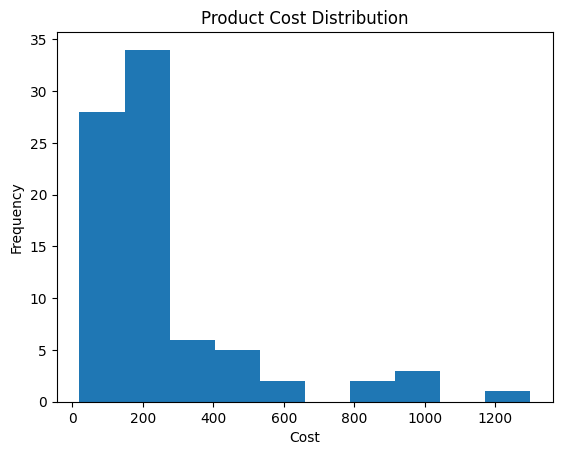

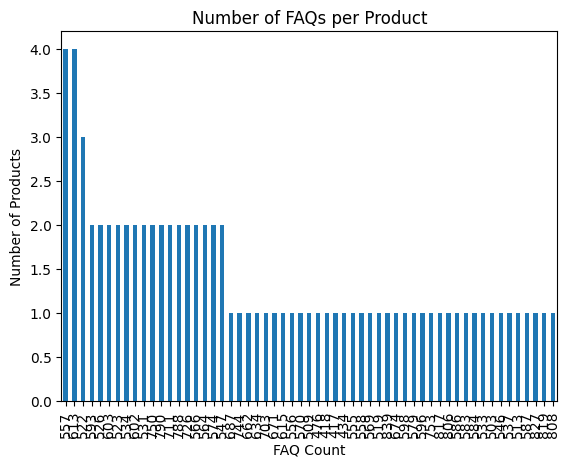

In [ ]:
# Load and analyze the Products dataset
products_df = pd.read_csv(os.path.join(OUT_FOLDER, "products") + ".csv")


# Analyze the structure of the dataset
print("Products Dataset Summary:")
print(products_df.info())
print(products_df.describe())
print(products_df.head())

# Visualization: Cost distribution of products
if 'COST' in products_df.columns:
    products_df['COST'].plot(kind='hist', title='Product Cost Distribution', bins=10)
    plt.xlabel('Cost')
    plt.ylabel('Frequency')
    plt.show()

# Analyze FAQs
if 'FAQs' in products_df.columns:
    faq_counts = products_df['FAQs'].apply(len).value_counts()
    faq_counts.plot(kind='bar', title='Number of FAQs per Product', ylabel='Number of Products', xlabel='FAQ Count')
    plt.show()


### Users

The users dataset provides information about the customers in the system, including their unique IDs, names, and email addresses. Analyzing this dataset helps in understanding the scale of the user base and identifying key patterns such as duplicate or incomplete user data.

In [ ]:
# Load and analyze the Users dataset
users_df = pd.read_csv(os.path.join(OUT_FOLDER, "users") + ".csv")

# Analyze the structure of the dataset
print("\nUsers Dataset Summary:")
print(users_df.info())
print(users_df.describe())
print(users_df.head())

# Analysis: Count unique users
unique_users = users_df['ID'].nunique()
print(f"Total unique users: {unique_users}")


Users Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      30 non-null     int64 
 1   NAME    30 non-null     object
 2   EMAIL   30 non-null     object
dtypes: int64(1), object(2)
memory usage: 852.0+ bytes
None
              ID
count  30.000000
mean   15.500000
std     8.803408
min     1.000000
25%     8.250000
50%    15.500000
75%    22.750000
max    30.000000
   ID           NAME                    EMAIL
0   1  Alice Johnson  alice.johnson@gmail.com
1   2      Bob Smith      bob.smith@gmail.com
2   3  Charlie Davis  charlie.davis@gmail.com
3   4      Diana Lee      diana.lee@gmail.com
4   5    Ethan Brown    ethan.brown@gmail.com
Total unique users: 30


### Experts

The experts dataset contains information about the customer service experts, including their areas of expertise. This dataset is crucial for matching tickets to appropriate experts based on their skills and expertise.


Experts Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           10 non-null     int64 
 1   NAME         10 non-null     object
 2   EMAIL        10 non-null     object
 3   DESCRIPTION  10 non-null     object
dtypes: int64(1), object(3)
memory usage: 452.0+ bytes
None
             ID
count  10.00000
mean    5.50000
std     3.02765
min     1.00000
25%     3.25000
50%     5.50000
75%     7.75000
max    10.00000
   ID                 NAME                            EMAIL  \
0   1     Dr. Emily Turner     dr..emily.turner@company.com   
1   2      Mr. Jack Miller      mr..jack.miller@company.com   
2   3    Ms. Sophia Carter    ms..sophia.carter@company.com   
3   4      Dr. Liam Wilson      dr..liam.wilson@company.com   
4   5  Mrs. Grace Thompson  mrs..grace.thompson@company.com   

                              DESCRIPTION  


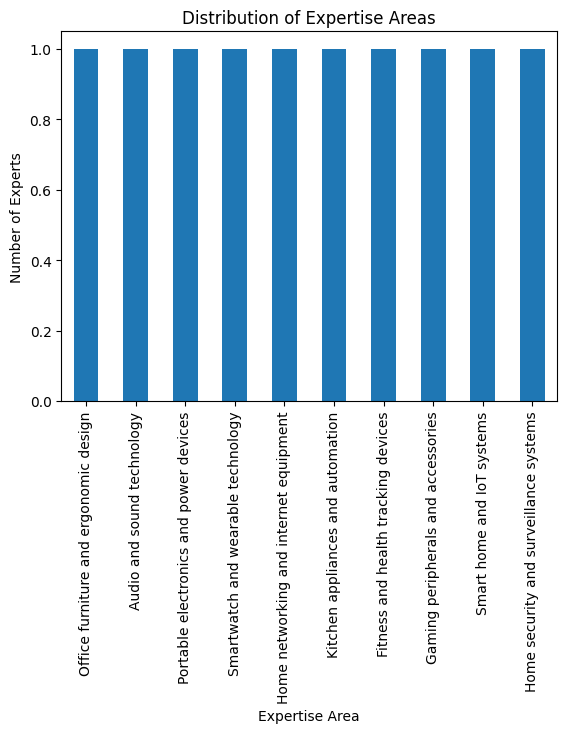

In [ ]:
# Load and analyze the Experts dataset
experts_df = pd.read_csv(os.path.join(OUT_FOLDER, "experts") + ".csv")

# Analyze the structure of the dataset
print("\nExperts Dataset Summary:")
print(experts_df.info())
print(experts_df.describe())
print(experts_df.head())

# Analysis: Expertise summary
expertise_summary = experts_df['DESCRIPTION'].value_counts()
print("\nExpertise Summary:")
print(expertise_summary)

# Visualization: Top areas of expertise
expertise_summary.plot(kind='bar', title='Distribution of Expertise Areas', ylabel='Number of Experts', xlabel='Expertise Area')
plt.show()


### Tickets

The tickets dataset includes information about customer issues, such as the priority, number of users affected, and descriptions of the issues. This dataset is key to understanding customer pain points and prioritizing their resolution.


Tickets Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           30 non-null     int64 
 1   USER_ID      30 non-null     int64 
 2   PRIORITY     30 non-null     object
 3   COUNTER      30 non-null     int64 
 4   DESCRIPTION  30 non-null     object
 5   ITEM_ID      30 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 1.5+ KB
None
              ID    USER_ID    COUNTER    ITEM_ID
count  30.000000  30.000000  30.000000  30.000000
mean   15.500000  14.866667  54.000000  15.500000
std     8.803408   7.762569  27.273835   8.803408
min     1.000000   1.000000   5.000000   1.000000
25%     8.250000   8.250000  34.250000   8.250000
50%    15.500000  14.500000  53.000000  15.500000
75%    22.750000  21.750000  78.500000  22.750000
max    30.000000  29.000000  98.000000  30.000000
   ID  USER_ID PRIORITY  COUNTER  \
0  

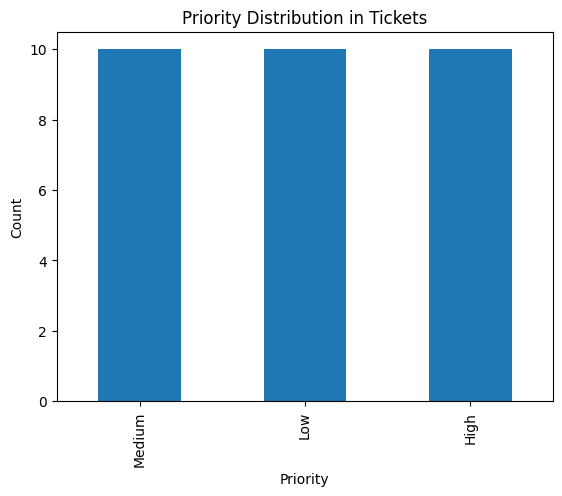


Most Common Issues:
DESCRIPTION
The power bank is overheating during use.                       4
The heart rate monitor is not working accurately.               4
I'm experiencing back pain after using the chair.               3
The armrests on my chair are not adjusting properly.            3
My router is not providing a stable internet connection.        3
My headphones are not connecting to my device via Bluetooth.    3
I'm experiencing slow internet speeds.                          3
The noise-cancellation feature is not working properly.         3
My power bank is not charging my device.                        2
My fitness watch is not syncing with my phone.                  2
Name: count, dtype: int64


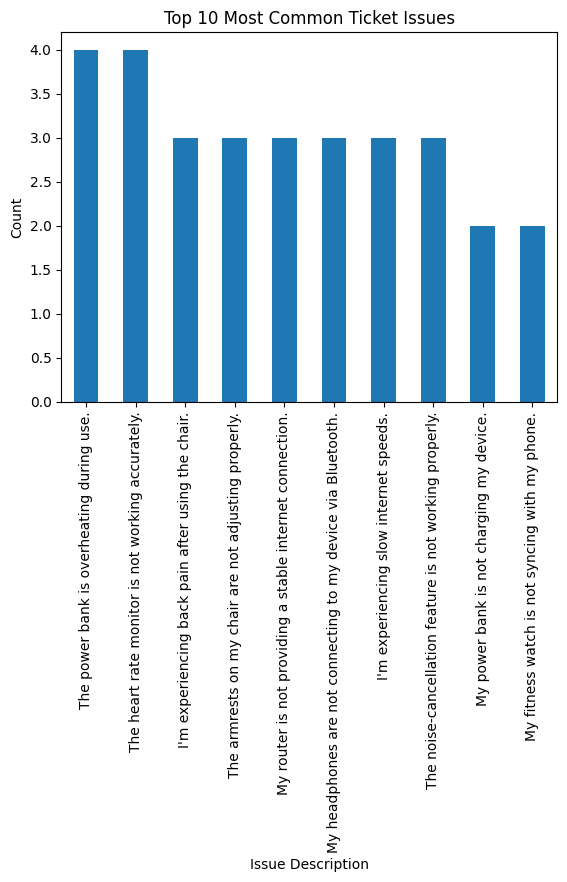

In [ ]:
# Load and analyze the Tickets dataset
tickets_df = pd.read_csv(os.path.join(OUT_FOLDER, "tickets") + ".csv")

# Analyze the structure of the dataset
print("\nTickets Dataset Summary:")
print(tickets_df.info())
print(tickets_df.describe())
print(tickets_df.head())

# Analysis: Priority distribution
tickets_priority_counts = tickets_df['PRIORITY'].value_counts()
print("\nPriority Distribution in Tickets:")
print(tickets_priority_counts)

# Visualization: Priority distribution
tickets_priority_counts.plot(kind='bar', title='Priority Distribution in Tickets', ylabel='Count', xlabel='Priority')
plt.show()

# Analysis: Most common issues
if 'DESCRIPTION' in tickets_df.columns:
    issue_counts = tickets_df['DESCRIPTION'].value_counts().head(10)
    print("\nMost Common Issues:")
    print(issue_counts)

    # Visualization: Top 10 issues
    issue_counts.plot(kind='bar', title='Top 10 Most Common Ticket Issues', ylabel='Count', xlabel='Issue Description')
    plt.show()

Our system will be designed to:
- read and interpret customer questions;
- look for previously resolved issues in for the same product;
- search for experts within or outside the company to forward requests to;
- check for existing tickets on the same matter;
- open new tickets for new issues;

Let's setup the SQL database and test with some queris.

In [ ]:
# Create a SQLite connection
conn = sqlite3.connect("lam_customer_service.db")
cursor = conn.cursor()

# Load DataFrames into SQLite tables
products_df.to_sql("Products", conn, if_exists="replace", index=False)
users_df.to_sql("Users", conn, if_exists="replace", index=False)
experts_df.to_sql("Experts", conn, if_exists="replace", index=False)
tickets_df.to_sql("Tickets", conn, if_exists="replace", index=False)

print("Datasets successfully loaded into SQLite!")

Datasets successfully loaded into SQLite!


Let's test SQL connection and analyze tables.

In [ ]:
# Function to visualize tables
def visualize_tables(conn):
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    print("\033[96m\033[1mTables in the database:\033[0m")
    for table in tables:
        print(f"\033[93m{table[0]}\033[0m")  # Table name in yellow
        df = pd.read_sql_query(f"SELECT * FROM {table[0]} LIMIT 5", conn)

        print(f"\033[93m\033[1mSample data from table '{table[0]}':\033[0m")
        print("\033[97m" + df.to_string(index=False) + "\033[0m")  # Data in white
        print("\033[94m" + "-" * 50 + "\033[0m")  # Separator in blue

# Function to test SQL queries
def run_queries(conn):
    print("\033[96m\nTesting some queries...\n\033[0m")

    # Query 1: Count the number of records in each table
    print("\033[93m\033[1m1. Count of records in each table:\033[0m")
    for table in ["Products", "Users", "Experts", "Tickets"]:
        query = f"SELECT COUNT(*) as count FROM {table}"
        result = pd.read_sql_query(query, conn)
        print(f"\033[92m{table}:\033[97m {result['count'].iloc[0]} records")

    print("\033[94m" + "-" * 50 + "\033[0m")

    # Query 2: Retrieve a sample of user emails (Users table)
    print("\033[93m\033[1m2. Sample user emails from the Users table:\033[0m")
    query = "SELECT ID, NAME, EMAIL FROM Users LIMIT 5"
    result = pd.read_sql_query(query, conn)
    print("\033[97m" + result.to_string(index=False) + "\033[0m")

    print("\033[94m" + "-" * 50 + "\033[0m")

    # Query 3: Find the top 5 high-priority tickets
    print("\033[93m\033[1m3. Top 5 high-priority tickets:\033[0m")
    query = """
        SELECT ID, USER_ID, PRIORITY, DESCRIPTION
        FROM Tickets
        WHERE PRIORITY = 'High'
        LIMIT 5
    """
    result = pd.read_sql_query(query, conn)
    print("\033[97m" + result.to_string(index=False) + "\033[0m")

    print("\033[94m" + "-" * 50 + "\033[0m")

    # Query 4: Retrieve experts specializing in 'router' (Experts table)
    print("\033[93m\033[1m4. Experts specializing in 'router':\033[0m")
    query = """
        SELECT ID, NAME, DESCRIPTION
        FROM Experts
        WHERE DESCRIPTION LIKE '%router%'
    """
    result = pd.read_sql_query(query, conn)
    print("\033[97m" + result.to_string(index=False) + "\033[0m")

    print("\033[94m" + "-" * 50 + "\033[0m")

    # Query 5: Find all tickets related to 'router' issues
    print("\033[93m\033[1m5. Tickets related to 'router' issues:\033[0m")
    query = """
        SELECT ID, USER_ID, DESCRIPTION
        FROM Tickets
        WHERE DESCRIPTION LIKE '%router%'
    """
    result = pd.read_sql_query(query, conn)
    print("\033[97m" + result.to_string(index=False) + "\033[0m")

    print("\033[94m" + "-" * 50 + "\033[0m")

# Create SQLite connection
conn = sqlite3.connect("lam_customer_service.db")

# Visualize the tables and run queries
visualize_tables(conn)
run_queries(conn)

# Close the connection
conn.close()

Tables in the database:
Products
Sample data from table 'Products':
 ID                                 NAME                                                                                                                                                                                                                                                                              DESCRIPTION   COST                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        FAQs

### Tool Definition
We can now define tools for our purposes.

In [ ]:
def send_email(to: str, subject: str, body: str) -> str:
    """
    Simulates sending an email by writing to a file.

    Args:
        to (str): The recipient's email address.
        subject (str): The subject of the email.
        body (str): The main content of the email.
    """
    # 1. Create the email content
    email_content = f"""
From: lam.system@gmail.com
To: {to}
Subject: {subject}

{body}
"""
    # 2. "Send" it (write to file)
    out_path = 'tmp_email_repo.txt'
    with open(out_path, "w") as f_out:
        f_out.write(email_content)

    # Return message to notify the LLM the task was completed successfully
    success_msg = f"The email to {to} was written and sent with SUCCESS. Well done. The task has been fulfilled."
    print(success_msg)

    return success_msg

send_email_interface = FunctionTool.from_defaults(
    fn=send_email,
    tool_metadata=ToolMetadata(
        name="send_email",
        description=(
            "Sends an email to a specific recipient. "
            "You must provide three specific arguments: 'to', 'subject', and 'body'. "
            "CRITICAL: The 'body' content MUST be concise (under 200 words)."
            "Summarize findings briefly; do not write long reports."
        )
    )
)

In [ ]:
def retrieve_similar_faqs(input: str = "Bluetooth", db_name: str = "lam_customer_service.db") -> str:
    """
    Searches for FAQs. Returns a string message if none are found.
    """
    redundant_words = ["issues", "issue", "problems", "problem", "troubles", "trouble"]
    cleaned_input = re.sub(r"\b(" + "|".join(redundant_words) + r")\b", "", input.lower()).strip()
    search_terms = cleaned_input.split() or ["Bluetooth"]

    where_clauses = " OR ".join(["LOWER(FAQs) LIKE ?" for _ in search_terms])
    params = [f"%{term}%" for term in search_terms]

    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    try:
        cursor.execute(f"SELECT NAME, FAQs FROM Products WHERE {where_clauses} LIMIT 5", params)
        results = cursor.fetchall()

        if not results:
            return "Observation: No relevant FAQs were found in the database."

        return str(results)
    except Exception as e:
        return f"Error: {e}"
    finally:
        conn.close()

retrieve_similar_faqs_interface = FunctionTool.from_defaults(
    fn=retrieve_similar_faqs,
    tool_metadata=ToolMetadata(
        name="retrieve_similar_faqs",
        description="Searches FAQs for a keyword. Returns matching product Q&A pairs."
    )
)

In [ ]:
def find_expert_in_domain(input: str = "audio", db_name: str = "lam_customer_service.db") -> str:
    """
    Finds experts. Returns a clear message if none are found.
    """
    search_terms = input.strip().lower().split()
    where_clauses = " OR ".join(["LOWER(DESCRIPTION) LIKE ?" for _ in search_terms])
    params = [f"%{term}%" for term in search_terms]

    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    try:
        cursor.execute(f"SELECT NAME, EMAIL, DESCRIPTION FROM Experts WHERE {where_clauses} LIMIT 5", params)
        results = cursor.fetchall()

        if not results:
            return "Observation: No experts were found matching this domain."

        return str(results)
    except Exception as e:
        return f"Error: {e}"
    finally:
        conn.close()

find_expert_in_domain_interface = FunctionTool.from_defaults(
    fn=find_expert_in_domain,
    tool_metadata=ToolMetadata(
        name="find_expert_in_domain",
        description="Finds experts in a specific domain. Use for technical queries not solved by FAQs."
    )
)

In [ ]:
from pydantic import BaseModel, Field

class TicketSchema(BaseModel):
    """
    Strict schema for opening tickets.
    Forces the LLM to use 'description' instead of 'input'.
    """
    description: str = Field(
        description="A clear, concise summary of the user's issue."
    )
    priority: str = Field(
        description="Priority level: 'Low', 'Medium', or 'High'. Default to 'Medium' if unsure.",
        default="Medium"
    )
    user_id: int = Field(
        description="The ID of the user. Default to 1 if unknown.",
        default=1
    )
    item_id: int = Field(
        description="The ID of the product. Default to 0 if unknown.",
        default=0
    )

def open_or_update_ticket(
    description: str,
    priority: str = "Medium",
    user_id: int = 1,
    item_id: int = 0,
    db_name: str = "lam_customer_service.db"
) -> str:
    """
    Opens a new ticket or updates an existing one.
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    try:
        # Check if ticket exists
        query_check = "SELECT ID, COUNTER FROM Tickets WHERE USER_ID=? AND ITEM_ID=? AND DESCRIPTION=?"
        cursor.execute(query_check, (user_id, item_id, description))
        ticket = cursor.fetchone()

        if ticket:
            new_counter = ticket[1] + 1
            cursor.execute("UPDATE Tickets SET COUNTER=? WHERE ID=?", (new_counter, ticket[0]))
            conn.commit()
            response = f"Ticket #{ticket[0]} updated. Counter increased to {new_counter}."
        else:
            cursor.execute(
                "INSERT INTO Tickets (USER_ID, PRIORITY, COUNTER, DESCRIPTION, ITEM_ID) VALUES (?, ?, 1, ?, ?)",
                (user_id, priority, description, item_id)
            )
            conn.commit()
            response = "New ticket opened successfully."

    except Exception as e:
        response = f"Error: {e}"
    finally:
        conn.close()

    return response

open_or_update_ticket_interface = FunctionTool.from_defaults(
    fn=open_or_update_ticket,
    name="open_or_update_ticket",
    fn_schema=TicketSchema,
    description=(
        "Opens a support ticket. "
        "REQUIRED: You must provide a 'description' field. "
        "OPTIONAL: 'priority', 'user_id', 'item_id'. "
        "WARNING: Do NOT use an 'input' argument."
    )
)

### Agent Setup

In [ ]:
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

    quantization_configs = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True)

    llm = HuggingFaceLLM(
        model_name=MODEL_NAME,
        max_new_tokens=8192,
        model_kwargs={
            "trust_remote_code": True,
            "attn_implementation" : "eager",
            "quantization_config" : quantization_configs
        },
        generate_kwargs={
            "do_sample": True,
            "temperature": 0.7,
            "top_k" : 20,
            "top_p" : 0.8,
            "min_p" : 0.0
        },
        tokenizer_name=MODEL_NAME,
        is_chat_model=True
    )

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Let's define a prompt for guiding the tool interactions.

In [ ]:
sql_instructions = """
### Role
You are a Universal Support Agent. Your job is to Log Everything. You must never reject a user query.

### EXECUTION FLOW (Do not deviate)

1. **PHASE 1: Knowledge Base Search** (`retrieve_similar_faqs`)
   - Search for keywords.
   - **IF** specific answer found: Rephrase and **STOP**.
   - **IF** "No relevant FAQs found": Go to PHASE 2.

2. **PHASE 2: Expert Search** (`find_expert_in_domain`)
   - Search for a technical domain.
   - **IF** "No experts found": Go to PHASE 3.
   - **IF** Expert found but IRRELEVANT (e.g. HR expert for IT issue): Go to PHASE 3.
   - **IF** Relevant Expert found: Send Email (`send_email`) and **STOP**.

3. **PHASE 3: The Catch-All Ticket** (`open_or_update_ticket`)
   - **CONDITION:** If Phase 1 and 2 provided no solution.
   - **ACTION:** You **MUST** open a ticket.
   - **CRITICAL RULE:** Even if the query seems nonsense, out of scope, or about "parking cars", "cooking", or "weather", **YOU MUST OPEN A TICKET**.
   - **Parameters**:
     - `description`: "User asking about [topic]: [summary of issue]"
     - `priority`: "Low" (for non-technical/random issues) or "Medium".
   - **Closing Statement:** "I couldn't find a document for this, so I have opened a general inquiry ticket for our team to review."

### FORBIDDEN BEHAVIORS
- **NEVER** say "I cannot assist."
- **NEVER** say "This is outside the scope."
- **NEVER** give up. If you don't know what to do, **OPEN A TICKET**.
"""

SYS_PROMPT = """
You are a helpful Hotline Support Agent designed to resolve user issues via FAQs, Experts, or Support Tickets.

## Tools
You have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.

You have access to the following tools:
{tool_desc}

## Instructions
{context}

## Output Format

Please answer in the same language as the question and use the following format:

Thought: The current language of the user is: (user's language). I need to use a tool to help me answer the question.
Action: tool name (one of {tool_names}) if using a tool.
Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})

Observation: tool response

You should keep repeating the above format until the task is resolved (either by finding an answer, sending an email, or opening a ticket).

At that point, you MUST respond in the following format:

Thought: I have completed the task (by answering, sending an email, or opening a ticket). I will now confirm the action to the user.
Answer: [Your final response to the user. E.g., "I have opened ticket #123 for you." or "I have forwarded your request to an expert."]

## IMPORTANT RULES FOR FINAL ANSWER
- **Never say "I cannot answer".** If you opened a ticket, you HAVE answered.
- **Consistency:** If a ticket was opened, your final answer must ALWAYS start with: "I have opened a support ticket..."
- **No Apologies:** Do not apologize for not finding an expert. State the action you took clearly.
"""

# Create a custom chat formatter with the new prompt
chat_formatter = ReActChatFormatter(system_header=SYS_PROMPT,
                                    context=sql_instructions)

Let's define a parsed for tool calls.

In [ ]:
def custom_tool_call_parser(tool_call: OpenAIToolCall) -> Dict:
    r"""Parse tool calls that are not standard json.
    Also parses tool calls of the following forms:
    variable = \"\"\"Some long text\"\"\"
    variable = "Some long text"'
    variable = '''Some long text'''
    variable = 'Some long text'
    """
    arguments_str = tool_call.function.arguments
    if len(arguments_str.strip()) == 0:
        return {}
    try:
        tool_call = json.loads(arguments_str)
        if not isinstance(tool_call, dict):
            raise ValueError("Tool call must be a dictionary")
        return tool_call
    except json.JSONDecodeError as e:
        pattern = r'([a-zA-Z_][a-zA-Z_0-9]*)\s*=\s*["\']+(.*?)["\']+'
        match = re.search(pattern, arguments_str)

        if match:
            variable_name = match.group(1)  # This is the variable name
            content = match.group(2)  # This is the content within the quotes
            return {variable_name: content}
        raise ValueError(f"Invalid tool call: {e!s}")

In [ ]:
# Add the tool to the agent
tools = [send_email_interface,
         retrieve_similar_faqs_interface,
         find_expert_in_domain_interface,
         open_or_update_ticket_interface]

# Define ReAct Agent
agent = ReActAgent(
    tools=tools,
    llm=llm,
    verbose=True,
    tool_call_parser=custom_tool_call_parser,
    react_chat_formatter=chat_formatter,
    max_iterations=30
)

### Experiments

#### Resolve Known Issues
Let's test the model on an issue which was previously resolved. We expect the LAM to fetch such information from the database and reformulate the answer.

In [ ]:
user_query = """My headphones are not connecting to my device via Bluetooth.
How can I resolve this issue?"""

response = await run_agent(user_query)

#### Contact an Expert
Let's pose a question that has not been resolved yet and falls within the domain of expertise of one of the available experts. We expect the model to identify that no relevant information is available and to generate an email to the expert detailing the user's issue.

In [ ]:
user_query = """My surveillance security system isn't connecting to the app. How can I pair these devices?"""

response = await run_agent(user_query)

#### Open a Ticket

Finally, we can test model abilities to open a new ticket.

In [ ]:
user_query = """I cannot park my car. Can you direct me to an expert?"""

response = await run_agent(user_query)

<a name="mcp"></a>
# 📤 Model Context Protocol

Let's now implement a simple single-agent pipeline using MCP servers and Langchain.

In [ ]:
!pip install -q mcp==1.24.0 \
                langchain==1.2.0 \
                langchain-community==0.4.1 \
                langchain-ollama==1.0.1 \
                langchain-tool==0.1.1

> **RESTART** the environment.

In [1]:
import asyncio
import json
import sys
from dataclasses import dataclass
from datetime import datetime
from typing import Any, Dict, List, Optional, TypedDict

import requests
from pydantic import BaseModel, Field

from mcp.server.fastmcp import FastMCP
from mcp.shared.memory import create_connected_server_and_client_session as client_session

# Local Open Source LLMs with Ollama
<a name="ollama"></a>

### How do we start Ollama in Colab?

To run **Ollama** in Colab, we need access to a terminal in which we will perform our operations.

"Technically" Colab's built-in terminal is typically a Pro-only feature, however, we can work around this limitation thanks to the `colab-xterm` extension!

This allows us to open a terminal directly inside the notebook.




In [ ]:
!pip install -q colab-xterm==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

Now let's deploy the model and make it accessible through API calls to a local address.

**RUN** the cell below to create a separate shell in background. Then, inside it, run the following commands:
- `curl -fsSL https://ollama.com/install.sh | sh` to download and configure ollama (you can ignore warnings);
- `ollama serve >/dev/null 2>&1 &` to deploy the ollama server endpoint for user requests
- `ollama pull granite4:3b` to download Llama;

You can ignore warnings.

In [ ]:
%xterm

> Once the models finish downloading, you can list all the currently available models on your machine with `ollama list`


In [ ]:
!ollama list

> ‼️ **NOTE** ‼️: Remember to launch the above terminal and `ollama serve` everytime you restart the colab environment.

## MCP Server

Before connecting to real APIs, let's define the **Interface**.
`FastMCP` allows us to define tools using standard Python type hints. This ensures the LLM receives a strict schema of exactly what data the tool expects and returns.

In this section, we define:
* **Data Models**: Structured classes (like `WeatherData`) that define the shape of our output.
* **Tools**: Functions decorated with `@mcp.tool()` that perform actions.

In [2]:
# Create server
mcp = FastMCP("Weather Service")

def get_coordinates(city_name: str) -> Optional[Dict[str, float]]:
    """Resolves a city name to Lat/Lon using Open-Meteo Geocoding"""
    try:
        url = "https://geocoding-api.open-meteo.com/v1/search"
        params = {"name": city_name, "count": 1, "language": "en", "format": "json"}
        resp = requests.get(url, params=params).json()
        if "results" in resp and resp["results"]:
            return {
                "lat": resp["results"][0]["latitude"],
                "lon": resp["results"][0]["longitude"],
                "name": resp["results"][0]["name"]
            }
    except Exception as e:
        print(f"Geocoding error for {city_name}: {e}")
    return None

# --- DATA MODELS ---

class WeatherData(BaseModel):
    """Real-time weather data"""
    city: str
    temperature: float = Field(description="Temperature in Celsius")
    wind_speed: float = Field(description="Wind speed in km/h")
    wind_direction: int = Field(description="Wind direction in degrees")
    is_day: bool = Field(description="True if it is currently daytime")
    timestamp: str = Field(description="Time of observation (ISO 8601)")

class WeatherAlert(BaseModel):
    """Official government weather alert"""
    area: str
    event: str
    severity: str
    headline: str
    description: str

class LocationMetrics(TypedDict):
    temperature: float
    wind_speed: float
    wind_gusts: float

Now we can define MCP tools simply by adding a function annotator.

In [3]:
@mcp.tool()
def get_weather(city: str) -> str:
    """Get current real-time weather for a city."""
    coords = get_coordinates(city)
    if not coords:
        return f"Error: Could not find location '{city}'"

    # Fetch from Open-Meteo
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": coords["lat"],
        "longitude": coords["lon"],
        "current": "temperature_2m,wind_speed_10m,wind_direction_10m,is_day"
    }

    try:
        resp = requests.get(url, params=params).json()
        curr = resp.get("current", {})

        data = WeatherData(
            city=coords["name"],
            temperature=curr.get("temperature_2m"),
            wind_speed=curr.get("wind_speed_10m"),
            wind_direction=curr.get("wind_direction_10m"),
            is_day=bool(curr.get("is_day")),
            timestamp=curr.get("time")
        )
        return data.model_dump_json()
    except Exception as e:
        return f"API Error: {str(e)}"

@mcp.tool()
def get_weather_metrics(cities: List[str]) -> Dict[str, LocationMetrics]:
    """Get critical flight metrics (Wind & Gusts) for multiple cities at once."""
    results = {}

    for city in cities:
        coords = get_coordinates(city)
        if not coords:
            continue

        try:
            url = "https://api.open-meteo.com/v1/forecast"
            params = {
                "latitude": coords["lat"],
                "longitude": coords["lon"],
                "current": "temperature_2m,wind_speed_10m,wind_gusts_10m"
            }
            resp = requests.get(url, params=params).json()
            curr = resp.get("current", {})

            results[city] = {
                "temperature": curr.get("temperature_2m"),
                "wind_speed": curr.get("wind_speed_10m"),
                "wind_gusts": curr.get("wind_gusts_10m", 0.0)
            }
        except:
            results[city] = {"error": "Failed to fetch"}

    return results

@mcp.tool()
def get_weather_alerts(us_state_code: str) -> List[WeatherAlert]:
    """
    Get active government weather alerts for a US State (e.g., 'CA', 'TX', 'NY').
    WARNING: Only works for US locations via NWS API.
    """
    url = f"https://api.weather.gov/alerts/active?area={us_state_code}"
    headers = {"User-Agent": "(my-weather-app, contact@example.com)"}

    try:
        resp = requests.get(url, headers=headers).json()
        alerts = []

        # Parse the Features from NWS GeoJSON
        for feature in resp.get("features", []):
            props = feature.get("properties", {})
            alerts.append(WeatherAlert(
                area=props.get("areaDesc", "Unknown Area"),
                event=props.get("event", "Unknown Event"),
                severity=props.get("severity", "Unknown"),
                headline=props.get("headline", ""),
                description=props.get("description", "")[:200] + "..." # Truncate for brevity
            ))

        return alerts
    except Exception as e:
        return []

Let's test the correct connectivity with the server's features.

In [4]:
from mcp.shared.memory import create_connected_server_and_client_session as client_session

async def test_mock_server() -> None:

    async with client_session(mcp._mcp_server) as client:
        # Test get_weather
        result = await client.call_tool("get_weather", {"city": "London"})
        print("\nWeather in London:")
        print(json.dumps(result.structuredContent, indent=2))

        # Test get_weather_metrics
        result = await client.call_tool("get_weather_metrics", {"cities": ["Tokyo", "Sydney", "Mumbai"]})
        print("\nWeather metrics:")
        print(json.dumps(result.structuredContent, indent=2))

await test_mock_server()


Weather in London:
{
  "result": "{\"city\":\"London\",\"temperature\":6.5,\"wind_speed\":5.2,\"wind_direction\":282,\"is_day\":false,\"timestamp\":\"2025-12-17T00:15\"}"
}

Weather metrics:
{
  "result": {
    "Tokyo": {
      "temperature": 6.3,
      "wind_speed": 1.1,
      "wind_gusts": 7.6
    },
    "Sydney": {
      "temperature": 25.1,
      "wind_speed": 9.8,
      "wind_gusts": 25.6
    },
    "Mumbai": {
      "temperature": 24.6,
      "wind_speed": 10.8,
      "wind_gusts": 14.8
    }
  }
}


## MCP Client

Now we have a working set of tools (the MCP Server), but we need a brain to use them.

We will use **LangGraph** to create a ReAct agent.
1.  **The Bridge**: We convert the MCP tools into LangChain-compatible tools using `mcp_to_langchain_tools`.
2.  **The Model**: We initialize `ChatOllama` (using a local ollama model `granite4:3b`).
3.  **The Agent**: We compile a graph that gives the LLM access to our weather tools.

In [6]:
from langchain_core.tools import StructuredTool
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

# CONFIG
OLLAMA_BASE_URL = "http://localhost:11434"
MODEL_NAME = "granite4:3b"

# 1. THE BRIDGE: FastMCP -> LangChain
def mcp_to_langchain_tools(mcp_server) -> List[StructuredTool]:
    """Auto-converts FastMCP tools into LangChain StructuredTools."""
    lc_tools = []
    for name, tool_obj in mcp_server._tool_manager._tools.items():
        lc_tool = StructuredTool.from_function(
            func=tool_obj.fn,
            name=name,
            description=tool_obj.description
        )
        lc_tools.append(lc_tool)
    return lc_tools

# 2. Prepare Tools & Model
tools = mcp_to_langchain_tools(mcp)
model = ChatOllama(base_url=OLLAMA_BASE_URL, model=MODEL_NAME, temperature=0)

print(f"Agent initialized with {len(tools)} tools.")

Agent initialized with 3 tools.


Let's now compile the agent graph.


We use `create_react_agent` to automatically build a state graph. The agent will:
1.  Receive a user question.
2.  Check if it has tools to answer the question.
3.  Call the tool (e.g., `get_weather`).
4.  Observe the output.
5.  Generate a final answer.

/tmp/ipython-input-541638174.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent_graph = create_react_agent(model, tools)


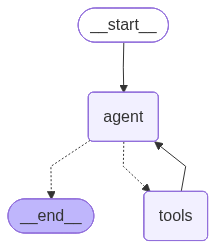

In [7]:
agent_graph = create_react_agent(model, tools)

agent_graph

Let's now test the MCP agent with a simple wheather comparison task.

In [8]:
from IPython.display import display, Markdown

scenario = "Compare wind speeds for Cesena, Bologna, and Brindisi. Which is safe?"

print(f"User: {scenario}")
print("Agent is thinking...\n")

# Invoke the agent
final_state = agent_graph.invoke({
    "messages": [HumanMessage(content=scenario)]
})

raw_output = final_state["messages"][-1].content
display(Markdown(raw_output))

User: Compare wind speeds for Cesena, Bologna, and Brindisi. Which is safe?
Agent is thinking...



**Current wind‑speed snapshot (all values are from the real‑time data you asked for, at 00:15 on 17 Dec 2025):**

| City      | Wind speed |
|-----------|------------|
| Cesena    | **5.8 m s⁻¹** (≈ 21 km/h) |
| Bologna   | **9.0 m s⁻¹** (≈ 33 km/h) |
| Brindisi  | **11.7 m s⁻¹** (≈ 42 km/h) |

### Which location is “safe”?

The term *safe* for aviation or outdoor activities usually means **low wind‑speed extremes**, because higher winds increase the risk of turbulence, reduced control authority, and hazardous gusts.

- **Cesena** has the lowest wind speed (5.8 m s⁻¹).  
  - This is comfortably below typical operational limits for most aircraft (< 20 kt) and poses minimal risk to pedestrians or outdoor events.
- **Bologna** sits at about 9 m s⁻¹, which is still within the normal operating envelope but approaches the upper‑limit of many small‑to‑medium aircraft. It’s generally safe for routine flights, but pilots would be cautious if they were preparing a take‑off or landing.
- **Brindisi** shows the strongest wind (11.7 m s⁻¹).  
  - This exceeds common safety thresholds for many light aircraft and could become problematic during low‑altitude flight operations, especially in cluttered airspace or near obstacles.

### Bottom line
**Cesena is currently the safest of the three locations regarding wind speed**, followed by Bologna. Brindisi’s wind is relatively strong for Cesena/Bologna but still manageable; however, if you need a truly “safe” spot for aviation or any activity that requires low wind (e.g., kite‑boarding with minimal gusts), **Cesena** is the best choice right now.

Let's analyze the reasoning+action workflow.

In [12]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from IPython.display import display, Markdown
import json

for msg in final_state["messages"]:
    if isinstance(msg, HumanMessage):
        display(Markdown(f"**User**: {msg.content}"))
        print("-" * 50)

    elif isinstance(msg, AIMessage):
        if msg.tool_calls:
            for tool_call in msg.tool_calls:
                print(f"Agent invoking tool: {tool_call['name']}")
                print(f"Arguments: {json.dumps(tool_call['args'])}")
        elif msg.content:
            display(Markdown(f"**Agent**: {msg.content}"))
        print("-" * 50)

    elif isinstance(msg, ToolMessage):
        try:
            data = json.loads(msg.content)
            print(f"Tool Output ({msg.name}):")
            print(json.dumps(data, indent=2))
        except:
            print(f"Tool Output ({msg.name}): {msg.content}")
        print("-" * 50)

**User**: Compare wind speeds for Cesena, Bologna, and Brindisi. Which is safe?

--------------------------------------------------
Agent invoking tool: get_weather
Arguments: {"city": "Cesena"}
--------------------------------------------------
Tool Output (get_weather):
{
  "city": "Cesena",
  "temperature": 7.8,
  "wind_speed": 5.8,
  "wind_direction": 292,
  "is_day": false,
  "timestamp": "2025-12-17T00:15"
}
--------------------------------------------------
Agent invoking tool: get_weather
Arguments: {"city": "Bologna"}
--------------------------------------------------
Tool Output (get_weather):
{
  "city": "Bologna",
  "temperature": 7.1,
  "wind_speed": 9.0,
  "wind_direction": 275,
  "is_day": false,
  "timestamp": "2025-12-17T00:15"
}
--------------------------------------------------
Agent invoking tool: get_weather
Arguments: {"city": "Brindisi"}
--------------------------------------------------
Tool Output (get_weather):
{
  "city": "Brindisi",
  "temperature": 13.6,
  "wind_speed": 11.7,
  "wind_direction": 146,
  "is_day": false,
  "timestamp": "2

**Agent**: **Current wind‑speed snapshot (all values are from the real‑time data you asked for, at 00:15 on 17 Dec 2025):**

| City      | Wind speed |
|-----------|------------|
| Cesena    | **5.8 m s⁻¹** (≈ 21 km/h) |
| Bologna   | **9.0 m s⁻¹** (≈ 33 km/h) |
| Brindisi  | **11.7 m s⁻¹** (≈ 42 km/h) |

### Which location is “safe”?

The term *safe* for aviation or outdoor activities usually means **low wind‑speed extremes**, because higher winds increase the risk of turbulence, reduced control authority, and hazardous gusts.

- **Cesena** has the lowest wind speed (5.8 m s⁻¹).  
  - This is comfortably below typical operational limits for most aircraft (< 20 kt) and poses minimal risk to pedestrians or outdoor events.
- **Bologna** sits at about 9 m s⁻¹, which is still within the normal operating envelope but approaches the upper‑limit of many small‑to‑medium aircraft. It’s generally safe for routine flights, but pilots would be cautious if they were preparing a take‑off or landing.
- **Brindisi** shows the strongest wind (11.7 m s⁻¹).  
  - This exceeds common safety thresholds for many light aircraft and could become problematic during low‑altitude flight operations, especially in cluttered airspace or near obstacles.

### Bottom line
**Cesena is currently the safest of the three locations regarding wind speed**, followed by Bologna. Brindisi’s wind is relatively strong for Cesena/Bologna but still manageable; however, if you need a truly “safe” spot for aviation or any activity that requires low wind (e.g., kite‑boarding with minimal gusts), **Cesena** is the best choice right now.

--------------------------------------------------
